In [5]:
import math
import glob

import matplotlib.pyplot as plt
import librosa
import torchaudio
import librosa.display
import pandas as pd
import soundfile as sf

from audio import *

from fastai.vision import *

ModuleNotFoundError: No module named 'audio'

## Creating spectrograms using Torchaudio

Internally, this code is similar to how fastai_audio is generating spectrograms. I included this here to experiment on params for spectrogram generation.

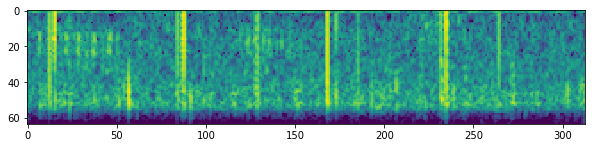

In [2]:
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB, MFCC

sig, sr = torchaudio.load(
    "output/damselfish/40.wav",
)

mel = MelSpectrogram(
    f_min=200.0,
    f_max=1000.0,
    hop_length=32,
    n_fft=128,
    n_mels=64,
    pad=0,
    win_length=None
)(sig)

mel = AmplitudeToDB(top_db=50)(mel)
mel = mel.detach()

plt.figure(figsize=(10,13))
p = plt.imshow(mel[0,:,:].detach().numpy())

## Model training at long last

Now that we have everything we need, we can start training a model.
In this next cell, we'll set up the parameters we want to use for generating Spectrograms with our `SpectrogramConfig()`.

These are the default parameters for `SpectrogramConfig`:

    f_min: float = 0.0
    f_max: float = 22050.0
    hop_length: int = 256
    n_fft: int = 2560
    n_mels: int = 128
    pad: int = 0
    to_db_scale: bool = True
    top_db: int = 100
    win_length: int = None
    n_mfcc: int = 20


These parameters can be overriden when creating a new config like so:

`SpectrogramConfig(n_mels=256, top_db=60)`

At the end of this cell, we create our `AudioList`. It will configure a category for each folder in `/tmp/output`, (we have two, `damselfish` and `noise`) and split those samples up into training and validation sets with a random split.

If you have trained the model, and want to change some parameters again, you should change values in this cell and then run this and the subsequent cells again.

Some more information about how these parameters are used can be found in the torchaudio documentation here: [pytorch documentation](https://pytorch.org/audio/transforms.html)

In [5]:
# Set a seed for reproducability
torch.manual_seed(0)

from fastai_audio.audio import SpectrogramConfig, AudioConfig

path = Path("output/")

sg_cfg = SpectrogramConfig(
    f_min=200.0,
    f_max=1000.0,
    hop_length=32,
    n_fft=128,
    n_mels=64,
    pad=0,
    win_length=None
)

config = AudioConfig(
    use_spectro=True,
    #delta=True,
    sg_cfg=sg_cfg,
)

al = AudioList.from_folder(path, config=config).split_by_rand_pct(.2, seed=4).label_from_folder()

## Transforms

The next cell sets up optional transforms for our spectrograms. These are more advanced techniques that come from some work at [Google](https://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html).

I am upscaling the size of our spectrograms from their defaults, but so far, I haven't had any luck masking freqencies and time. 

------------------------------------------------------------
File: output/damselfish/37.wav
Total Length: 2.0 seconds
Number of Channels: 1
Label: damselfish


Channel 0.0 (128x626):


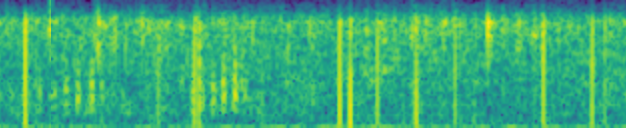

------------------------------------------------------------
File: output/damselfish/27.wav
Total Length: 2.0 seconds
Number of Channels: 1
Label: damselfish


Channel 0.0 (128x626):


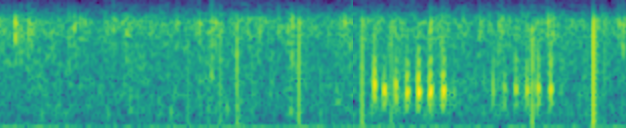

------------------------------------------------------------
File: output/damselfish/256.wav
Total Length: 2.0 seconds
Number of Channels: 1
Label: damselfish


Channel 0.0 (128x626):


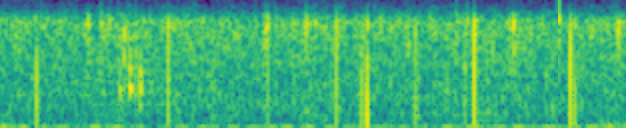

------------------------------------------------------------
File: output/damselfish/47.wav
Total Length: 2.0 seconds
Number of Channels: 1
Label: damselfish


Channel 0.0 (128x626):


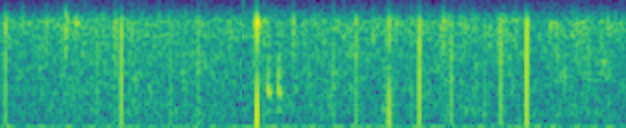

------------------------------------------------------------
File: output/damselfish/32.wav
Total Length: 2.0 seconds
Number of Channels: 1
Label: damselfish


Channel 0.0 (128x626):


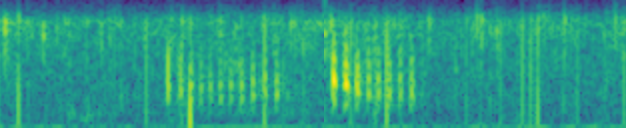

In [6]:
tfms = None
#tfms = get_spectro_transforms(mask_time=False, mask_freq=True, roll=False, num_rows=12)
tfms = get_spectro_transforms(
    size=(128, 626), # Upscale the spectrograms from 64x313
    mask_frequency=False, # Don't mask frequencies
    mask_time=False # Don't mask time
)
db = al.transform(tfms).databunch(bs=10)
db.show_batch(5)

## Create the learner and find a learning rate

In this cell, we create our learner, select an architecture and find a learning rate.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


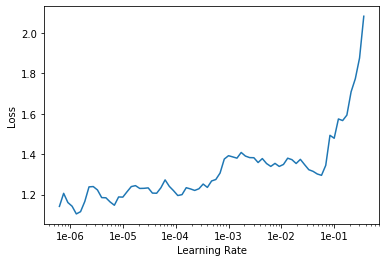

In [5]:
learn = audio_learner(db, base_arch=models.resnet50)
learn.lr_find()
learn.recorder.plot()

## Train the model

After selecting a learning rate, we can begin to train our model. During each epoch, you will see stats like:

    epoch 	train_loss 	valid_loss 	accuracy 	time
      0 	  0.823691 	  1.401638 	  0.593750 	00:07

In the [fast.ai video](https://youtu.be/ccMHJeQU4Qw?t=2936), Jeremy mentions that you never want to see a training loss that is higher than the valid loss. If you do, you should increase your learning rate, or increase the number of epochs. These are the two parameters that are passed to `fit_one_cycle` below.


In [6]:
learn.fit_one_cycle(20, slice(2e-2))

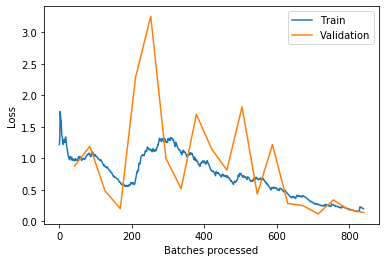

In [15]:
learn.recorder.plot_losses()

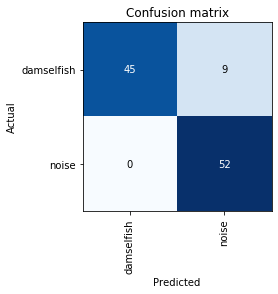

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [16]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(2e-2/10))

In [19]:
learn.export("new_spectrograms")

In [1]:
tmpfile="output/damselfish/30.wav"
item = AudioItem(path=tmpfile)
(category, _, _) = audio_predict(learn, item)
category

NameError: name 'AudioItem' is not defined

In [2]:
learn = audio_learner(db, base_arch=models.densenet161)
learn.load("/tmp/output/models/new_spectrograms")
learn.model.eval()

NameError: name 'audio_learner' is not defined

In [ ]:
import torchaudio
import pandas as pd
import soundfile as sf
import os

def search_file_for_samples(filepath, model, offset=2):
    df = pd.DataFrame(columns=["start", "end", "filepath"])

    si, ei = torchaudio.info(filepath)
    length = si.length / si.rate

    for i in range(0, 1000, offset):
        end = i + offset

        y, sr = librosa.load(
            filepath,
            sr=5000,
            offset=i,
            duration=2,
        )
        tmpfile = f"/tmp/potentials/{os.path.basename(filepath)[:-4]}-{i}.wav"
        sf.write(tmpfile, y, 5000)
        item = AudioItem(path=tmpfile)
        category, _, _ = audio_predict(learn, item)
        if str(category) == "damselfish":
            df = df.append([{"start": i, "end": end, "filepath": filepath}])
        else:
            os.remove(tmpfile)
        
    return df

In [15]:
from subprocess import call

def fetch_recording(gs_path):
  return_code = call(["gsutil", "cp", gs_path, "/tmp/recordings/"])
  print(return_code)
fetch_recording("gs://sonumator/recordings/2015-2016/20151028-180505.wav")

0


In [16]:
learn.model.eval()
df = search_file_for_samples("/tmp/recordings/20151028-180505.wav", learn)
df.index = range(len(df.index))
df

start  end                             filepath
0     30   32  /tmp/recordings/20151028-180505.wav
1     56   58  /tmp/recordings/20151028-180505.wav
2     72   74  /tmp/recordings/20151028-180505.wav
3     80   82  /tmp/recordings/20151028-180505.wav
4     82   84  /tmp/recordings/20151028-180505.wav
5    106  108  /tmp/recordings/20151028-180505.wav
6    118  120  /tmp/recordings/20151028-180505.wav
7    126  128  /tmp/recordings/20151028-180505.wav
8    146  148  /tmp/recordings/20151028-180505.wav
9    164  166  /tmp/recordings/20151028-180505.wav
10   174  176  /tmp/recordings/20151028-180505.wav
11   184  186  /tmp/recordings/20151028-180505.wav
12   186  188  /tmp/recordings/20151028-180505.wav
13   196  198  /tmp/recordings/20151028-180505.wav
14   202  204  /tmp/recordings/20151028-180505.wav
15   212  214  /tmp/recordings/20151028-180505.wav
16   240  242  /tmp/recordings/20151028-180505.wav
17   246  248  /tmp/recordings/20151028-180505.wav
18   252  254  /tmp/recordings/20151028-180505.wav
19   260  262  /tmp/recordings/20151028-180505.wav
20   294  296  /tmp/recordings/20151028-180505.wav
21   350  352  /tmp/recordings/20151028-180505.wav
22   364  366  /tmp/recordings/20151028-180505.wav
23   372  374  /tmp/recordings/20151028-180505.wav
24   374  376  /tmp/recordings/20151028-180505.wav
25   400  402  /tmp/recordings/20151028-180505.wav
26   420  422  /tmp/recordings/20151028-180505.wav
27   446  448  /tmp/recordings/20151028-180505.wav
28   448  450  /tmp/recordings/20151028-180505.wav
29   482  484  /tmp/recordings/20151028-180505.wav
30   502  504  /tmp/recordings/20151028-180505.wav
31   514  516  /tmp/recordings/20151028-180505.wav
32   516  518  /tmp/recordings/20151028-180505.wav
33   528  530  /tmp/recordings/20151028-180505.wav
34   532  534  /tmp/recordings/20151028-180505.wav
35   534  536  /tmp/recordings/20151028-180505.wav
36   540  542  /tmp/recordings/20151028-180505.wav
37   564  566  /tmp/recordings/20151028-180505.wav
38   584  586  /tmp/recordings/20151028-180505.wav
39   666  668  /tmp/recordings/20151028-180505.wav
40   672  674  /tmp/recordings/20151028-180505.wav
41   692  694  /tmp/recordings/20151028-180505.wav
42   744  746  /tmp/recordings/20151028-180505.wav
43   770  772  /tmp/recordings/20151028-180505.wav
44   828  830  /tmp/recordings/20151028-180505.wav
45   830  832  /tmp/recordings/20151028-180505.wav
46   848  850  /tmp/recordings/20151028-180505.wav
47   858  860  /tmp/recordings/20151028-180505.wav
48   902  904  /tmp/recordings/20151028-180505.wav
49   930  932  /tmp/recordings/20151028-180505.wav
50   982  984  /tmp/recordings/20151028-180505.wav
51   988  990  /tmp/recordings/20151028-180505.wav

In [ ]:
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB, MFCC
from IPython.display import Audio

from os import listdir
from os.path import isfile, join

def show(filename):
  sig, sr = torchaudio.load(
      filename,
  )

  # TODO: Configure values here
  mel = MelSpectrogram(
    f_min=200.0,
    f_max=1000.0,
    hop_length=32,
    n_fft=128,
    n_mels=64,
    pad=0,
    win_length=None
  )(sig)

  mel = AmplitudeToDB(top_db=50)(mel)
  mel = mel.detach()

  print(f"Filename {filename}")
  display(Audio(filename))
  plt.figure(figsize=(10,14))
  plt.imshow(mel[0,:,:].detach().numpy(), origin="lower")
  plt.show()

Filename /tmp/potentials/20151028-180505-106.wav


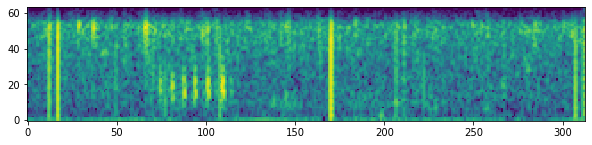

Filename /tmp/potentials/20151028-180505-118.wav


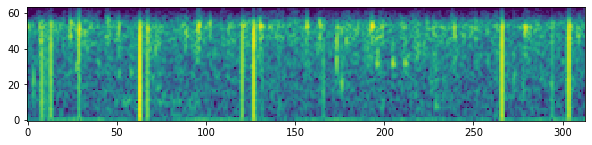

Filename /tmp/potentials/20151028-180505-126.wav


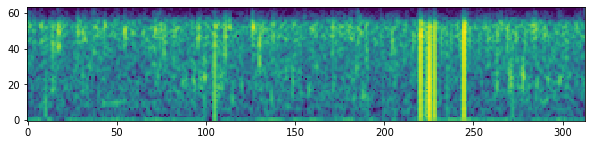

Filename /tmp/potentials/20151028-180505-146.wav


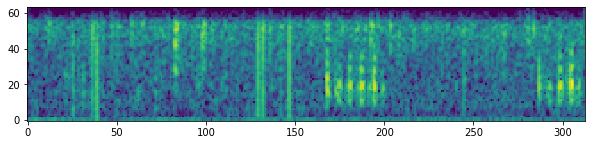

Filename /tmp/potentials/20151028-180505-164.wav


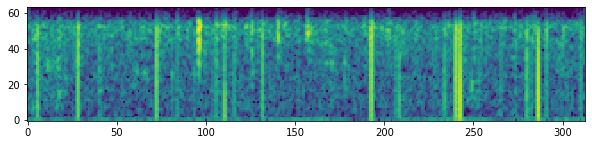

Filename /tmp/potentials/20151028-180505-174.wav


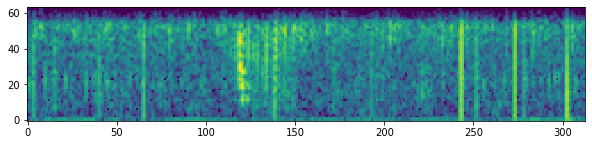

Filename /tmp/potentials/20151028-180505-184.wav


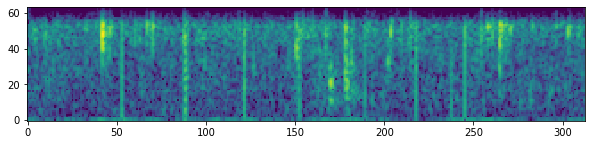

Filename /tmp/potentials/20151028-180505-186.wav


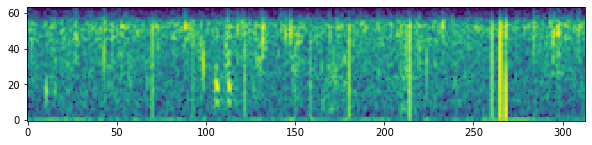

Filename /tmp/potentials/20151028-180505-196.wav


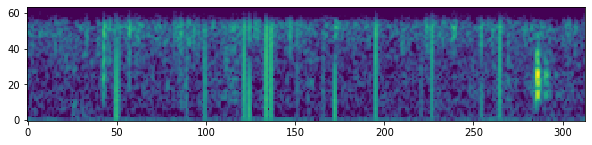

Filename /tmp/potentials/20151028-180505-202.wav


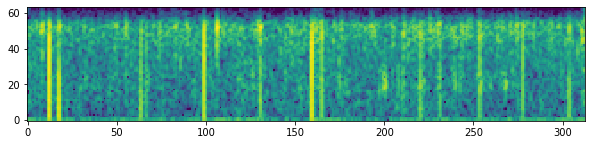

Filename /tmp/potentials/20151028-180505-212.wav


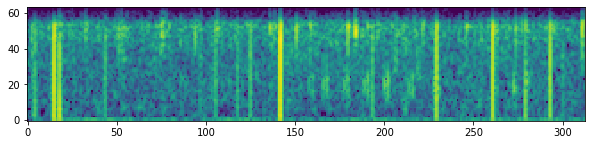

Filename /tmp/potentials/20151028-180505-240.wav


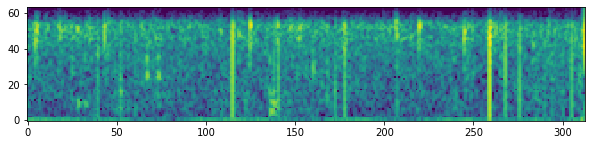

Filename /tmp/potentials/20151028-180505-246.wav


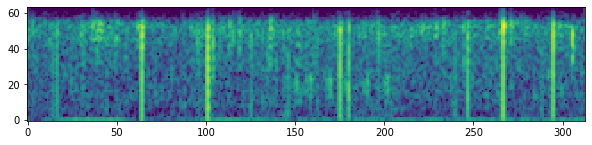

Filename /tmp/potentials/20151028-180505-252.wav


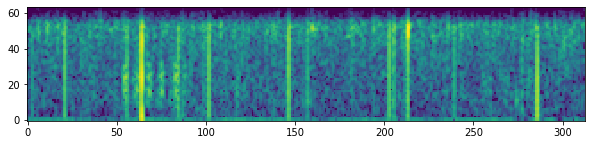

Filename /tmp/potentials/20151028-180505-260.wav


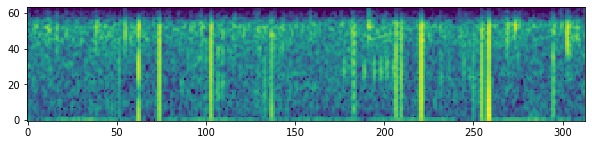

Filename /tmp/potentials/20151028-180505-294.wav


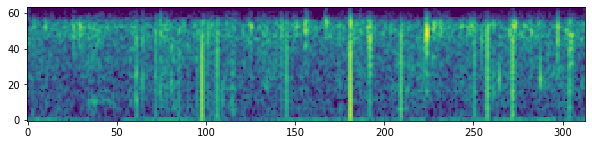

Filename /tmp/potentials/20151028-180505-30.wav


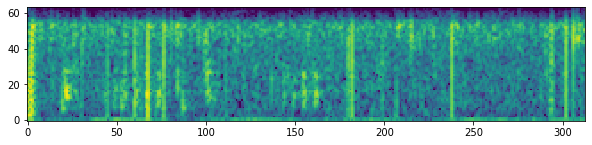

Filename /tmp/potentials/20151028-180505-350.wav


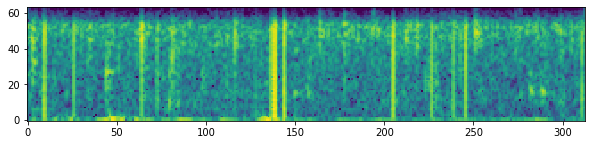

Filename /tmp/potentials/20151028-180505-364.wav


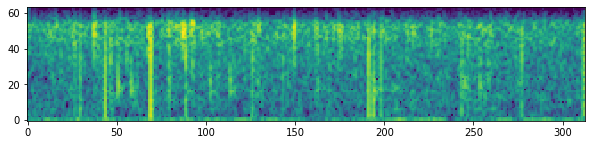

Filename /tmp/potentials/20151028-180505-372.wav


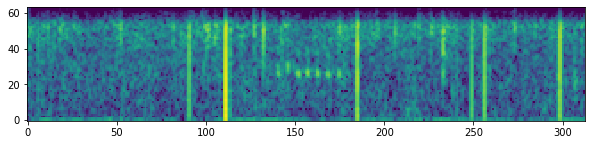

Filename /tmp/potentials/20151028-180505-374.wav


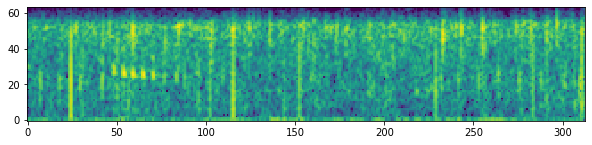

Filename /tmp/potentials/20151028-180505-400.wav


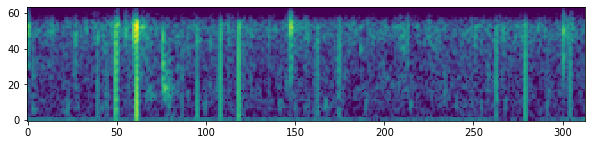

Filename /tmp/potentials/20151028-180505-420.wav


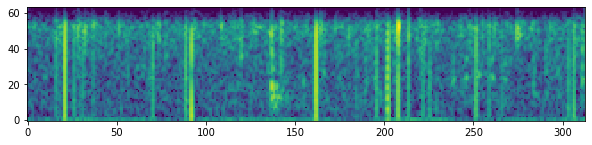

Filename /tmp/potentials/20151028-180505-446.wav


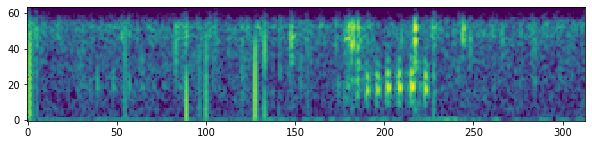

Filename /tmp/potentials/20151028-180505-448.wav


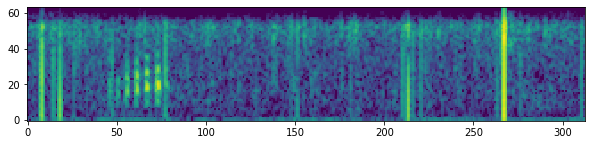

Filename /tmp/potentials/20151028-180505-482.wav


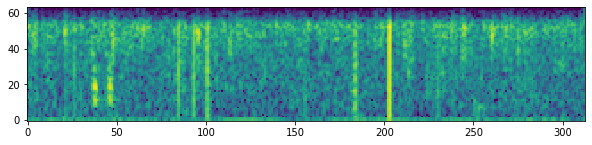

Filename /tmp/potentials/20151028-180505-502.wav


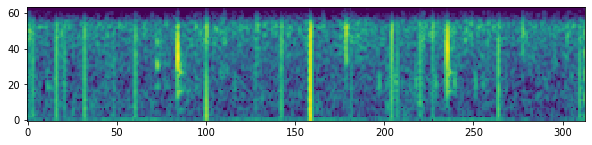

Filename /tmp/potentials/20151028-180505-514.wav


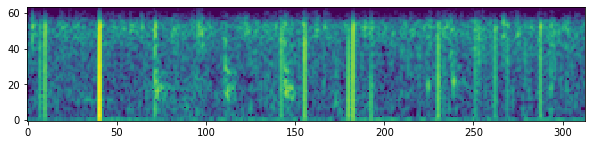

Filename /tmp/potentials/20151028-180505-516.wav


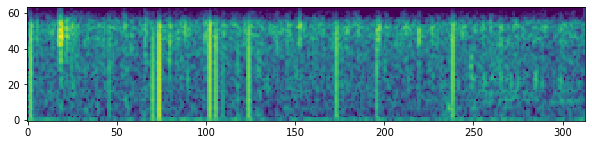

Filename /tmp/potentials/20151028-180505-528.wav


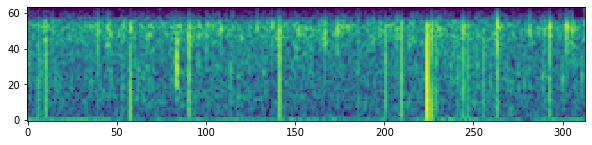

Filename /tmp/potentials/20151028-180505-532.wav


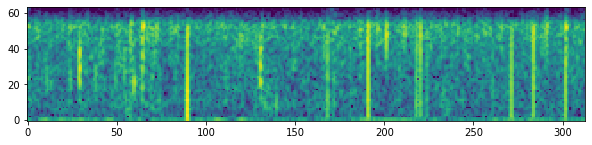

Filename /tmp/potentials/20151028-180505-534.wav


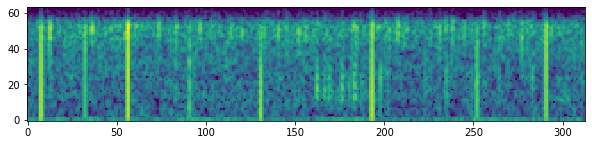

Filename /tmp/potentials/20151028-180505-540.wav


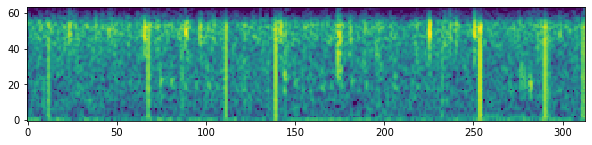

Filename /tmp/potentials/20151028-180505-56.wav


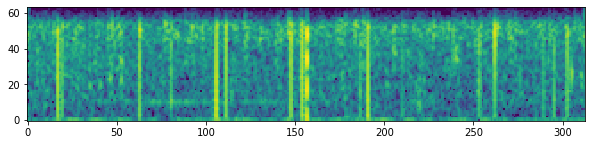

Filename /tmp/potentials/20151028-180505-564.wav


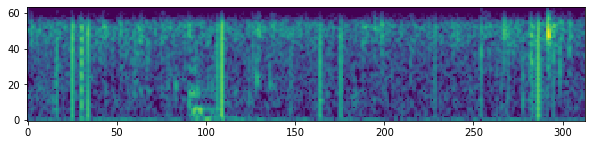

Filename /tmp/potentials/20151028-180505-584.wav


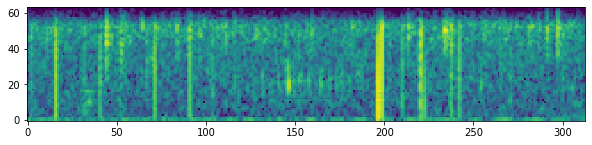

Filename /tmp/potentials/20151028-180505-666.wav


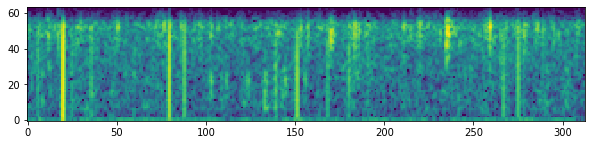

Filename /tmp/potentials/20151028-180505-672.wav


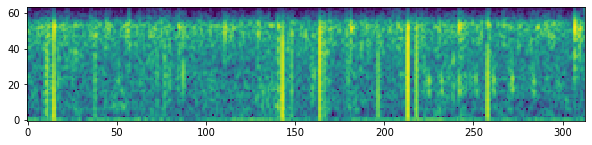

Filename /tmp/potentials/20151028-180505-692.wav


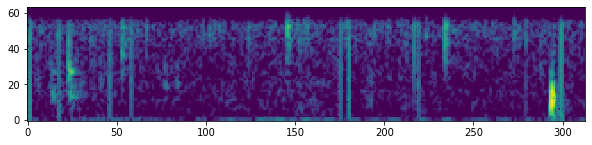

Filename /tmp/potentials/20151028-180505-72.wav


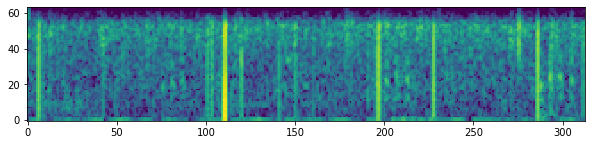

Filename /tmp/potentials/20151028-180505-744.wav


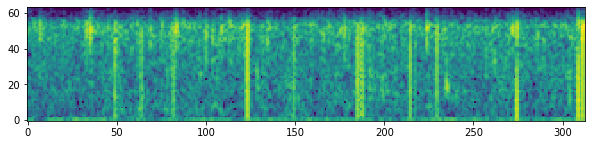

Filename /tmp/potentials/20151028-180505-770.wav


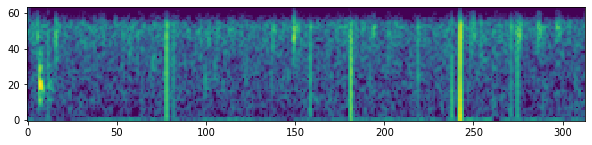

Filename /tmp/potentials/20151028-180505-80.wav


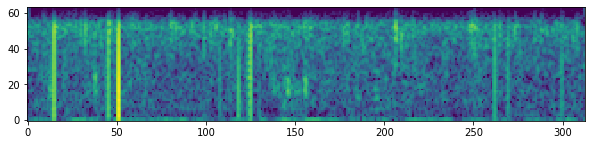

Filename /tmp/potentials/20151028-180505-82.wav


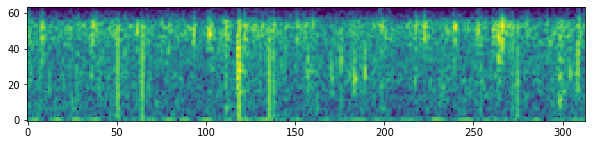

Filename /tmp/potentials/20151028-180505-828.wav


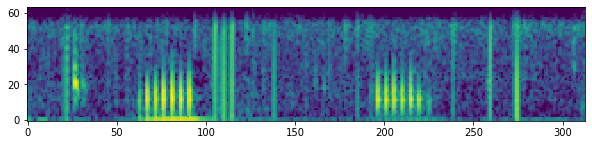

Filename /tmp/potentials/20151028-180505-830.wav


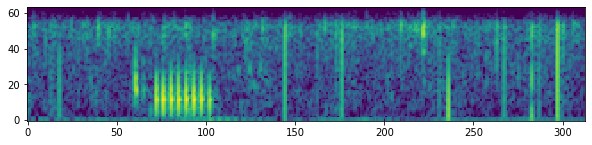

Filename /tmp/potentials/20151028-180505-848.wav


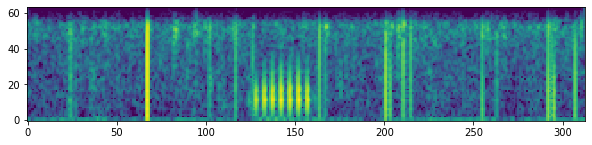

Filename /tmp/potentials/20151028-180505-858.wav


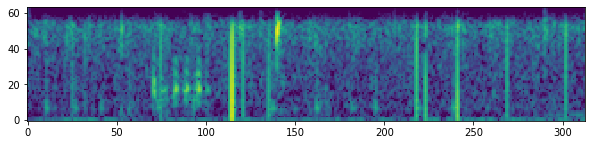

Filename /tmp/potentials/20151028-180505-902.wav


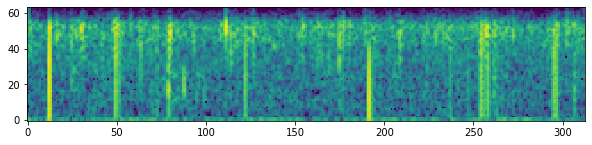

Filename /tmp/potentials/20151028-180505-930.wav


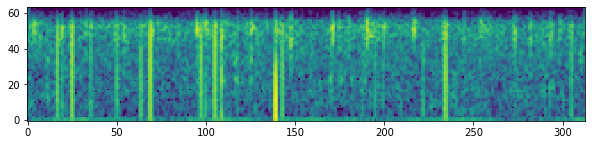

Filename /tmp/potentials/20151028-180505-982.wav


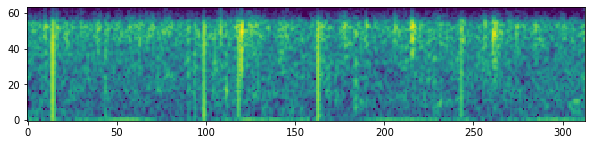

Filename /tmp/potentials/20151028-180505-988.wav


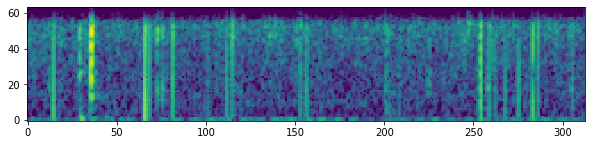

In [18]:
mypath = "/tmp/potentials/"
potentials = [f"{mypath}{f}" for f in listdir(mypath) if isfile(join(mypath, f))]
potentials.sort()

for i in range(0, len(potentials)):
  show(potentials[i])